[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/choidami/inductive-oocr/blob/main/parity/plot_for_parity.ipynb)

In [1]:
import io
import math
import os
import yaml
import json
import tiktoken

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({
    'font.size': 15,
    'ytick.labelsize': 14,
    'xtick.labelsize': 14,
})

from typing import List
from functools import partial
from collections import defaultdict

In [2]:
# @title Collect Results
def get_prob_for_parity(row, eval_name, normalize=False):
    # First, approximate the probability of each unique completion
    # by measuring the frequency (count(completion) / number of samples).
    comps = row.completions
    counts = dict(zip(*np.unique(comps, return_counts=True)))
    lp_choices = {comp: np.log(count / sum(counts.values()))
                  for comp, count in counts.items()}

    # Define mappings that map completions to groups.
    if eval_name.startswith('cross_function_control'):
        # Here, we map english words into true or false buckets.
        map = {row.true_str: 'true_str', row.false_str: 'false_str'}
        corr_label = map[row.expected_response]
    elif eval_name == 'inverse_query':
        # Here, we map variables into being equal to 1 or 0.
        map = {}
        for var in row.choices:
            map[var] = int(row.value) if var in row.corr_vars else 1 - row.value
        corr_label = row.value
    else:
        map = {c: c for c in row.choices}
        corr_label = row.expected_response

    # Compute the probability of each group.
    # This is necessary for the computation of the baseline.
    # Note, that the P(target) = P(group that target belongs to).
    out = {f'prob_{map[c]}': 0 for c in row.choices}
    corr_prob = 0
    valid_probs = 0
    for comp, lp in lp_choices.items():
        if comp in map:
            label = map[comp]
            out[f'prob_{label}'] += np.exp(lp)
            if label == corr_label:
                corr_prob += np.exp(lp)
            valid_probs += np.exp(lp)
    if normalize:
        out = {key: (prob / valid_probs if valid_probs > 0 else 0)
               for key, prob in out.items()}
        corr_prob = (corr_prob / valid_probs) if valid_probs > 0 else 0

    out['valid_probs'] = valid_probs
    out['prob'] = corr_prob
    out['corr_label'] = corr_label
    out['eval_name'] = eval_name
    return out


def compute_baseline(row, full_df, eval_name):
    df = full_df[full_df.eval_name == eval_name]
    return np.nanmean(df[f'prob_{row.corr_label}'].values)


def collect_eval(eval_name, exp_name, eval_path,
                 normalize=False, overwrite=False):
    parsed_results_path = os.path.join(eval_path, 'parsed_results.pkl')
    if os.path.isfile(parsed_results_path) and not overwrite:
        return pd.read_pickle(parsed_results_path)

    results_path = os.path.join(eval_path, 'results.pkl')
    if not os.path.isfile(results_path):
        print(f'NO results in {eval_path}')
        return None

    # Load results.
    results_df = pd.read_pickle(results_path)

    if exp_name.split('_')[-1].isdigit():
        run_id = int(exp_name.split('_')[-1])
        results_df['run_id'] = run_id
        exp_name = exp_name.removesuffix(f'_{run_id}')
    else:
        results_df['run_id'] = 0
    results_df['exp_name'] = exp_name

    if eval_name == 'length':
        # Filter out in-distribution lengths.
        id_lengths = [4, 5, 6]
        results_df = results_df[~results_df.total_length.isin(id_lengths)]
    if eval_name == 'cross_function_control_inv':
        eval_name = 'cross_function_control'

    apply_func = partial(get_prob_for_parity,
                         eval_name=eval_name,
                         normalize=normalize)
    results_df = pd.concat([results_df,
                            results_df.apply(apply_func,
                                             result_type='expand',
                                             axis=1)], axis=1)

    # Only evaluate baselines for trained models,
    # and not for in-context baselines.
    if 'ic_baseline' not in eval_path:
        get_baseline_func = partial(
            compute_baseline, full_df=results_df, eval_name=eval_name)
        results_df['bs_prob'] = results_df.apply(get_baseline_func, axis=1)

    results_df.to_pickle(parsed_results_path)

    return results_df


def collect_results(exp_base_path, normalize=False, overwrite=False):
    all_evals = []
    for exp_name in os.listdir(exp_base_path):
        exp_path = os.path.join(exp_base_path, exp_name)
        if not os.path.isdir(exp_path):
            continue

        ic_baseline_dirs = [dir for dir in os.listdir(exp_path)
                            if dir.startswith('ic_baseline_')]
        gpt_dirs = ['last_ckpt']

        for eval_dir in (gpt_dirs + ic_baseline_dirs):
            eval_base_path = os.path.join(exp_path, eval_dir)
            if not os.path.isdir(eval_base_path):
                continue

            for eval_name in os.listdir(eval_base_path):
                eval_path = os.path.join(eval_base_path, eval_name)
                if not os.path.isdir(eval_path):
                    continue

                results_df = collect_eval(
                    eval_name, exp_name, eval_path,
                    normalize=normalize, overwrite=overwrite)
                if results_df is not None:
                    if eval_dir == 'last_ckpt':
                        results_df['run_type'] = 'none'
                        results_df['ckpt'] = 'last'
                    elif eval_dir.startswith('ic_baseline_'):
                        results_df['run_type'] = 'ic_baseline'
                        results_df['ic_bs_size'] = int(eval_dir.split('_')[-1])
                        results_df['ic_bs_seed'] = int(eval_dir.split('_')[-2])
                    else:
                        raise ValueError()
                    all_evals.append(results_df)

    all_evals_df = pd.concat(all_evals)
    return all_evals_df

In [3]:
# @title Plotting Code
def bootstrap_ci(run_means, n=1000, ci_level=0.9):
    samples = np.random.choice(run_means, size=(n, len(run_means)), replace=True)
    bootstrap_means = np.mean(samples, axis=1)

    mean = np.mean(bootstrap_means)
    alpha = 1 - ci_level
    lower = np.percentile(bootstrap_means, alpha / 2 * 100)
    upper = np.percentile(bootstrap_means, (1 - alpha / 2) * 100)
    return mean, lower, upper


def plot_metric(df, ax, x, name='prob', plot_line=False, plot_err=True,
                add_legend=False, legend_label=None,
                plot_run_markers=False, incl_indv_legend=False, color='black'):
    # For each run, compute mean probs.
    run_means = df.groupby('run_id')[name].mean()
    # Mean over runs.
    mean, lower, upper = bootstrap_ci(run_means)
    err = [[mean - lower], [upper - mean]] if plot_err else None
    legend_label = legend_label if add_legend else None
    alpha = 1.0 if color == 'black' else 0.6

    ax.errorbar(x, mean, yerr=err, alpha=0.8, label=legend_label, ls='none',
                marker='o', c=color, capsize=7.0, capthick=1.0, ms=8)


def plot_exp(data_df, exp_name, title=None):
    eval_names = [
        ('in_dist', 'ID'),
        ('length', 'Length'),
        ('direct_print', 'Print (Python)'),
        ('direct_print_nl', 'Print (NL)'),
        ('mixed_ic_int', 'Mixed IC (int)'),
        ('mixed_ic_var', 'Mixed IC (var)'),
        ('cross_function_string', 'String'),
        ('cross_function_div', 'Div.'),
        ('cross_function_control', 'Control'),
        ('equality', 'Equality'),
        ('inverse_query', 'Reversal'),
    ]

    fig, ax = plt.subplots(figsize=(8, 4))

    exp_df = data_df[data_df.exp_name == exp_name]

    tick_labels = []
    for i, (eval_name, eval_name_label) in enumerate(eval_names):
        eval_df = exp_df[exp_df.eval_name == eval_name]

        df = eval_df[eval_df.ckpt == 'last']
        plot_metric(
            df, ax, i, name='prob', plot_err=True,
            add_legend=(i == 0), legend_label='Inductive OOCR',
            color='black')

        # In-context baseline.
        if 'ic_bs_size' in eval_df:
            ic_df = eval_df[eval_df.ic_bs_size.notnull()]
            ic_df = ic_df.groupby(
                ['run_id', 'ic_bs_seed', 'ic_bs_size'], as_index=False
            ).prob.mean()
            ic_df = ic_df.groupby('run_id', as_index=False).prob.max()
            plot_metric(
                ic_df, ax, i, name='prob', plot_err=True,
                add_legend=(i == 0), legend_label='In-Context',
                color='tab:green')

        # Other-query baseline.
        plot_metric(
            df, ax, i, name='bs_prob', plot_err=True,
            add_legend=(i == 0), legend_label='Baseline',
            color='tab:red')

        tick_labels.append(eval_name_label)

    ax.set_xticks(np.arange(len(eval_names)))
    ax.set_xticklabels(tick_labels, rotation=45, ha='right')
    ax.set_ylim(-0.05, 1.05)
    ax.set_ylabel(f'Mean P(target)')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.grid()
    if title is not None:
        ax.set_title(title)
    fig.tight_layout()

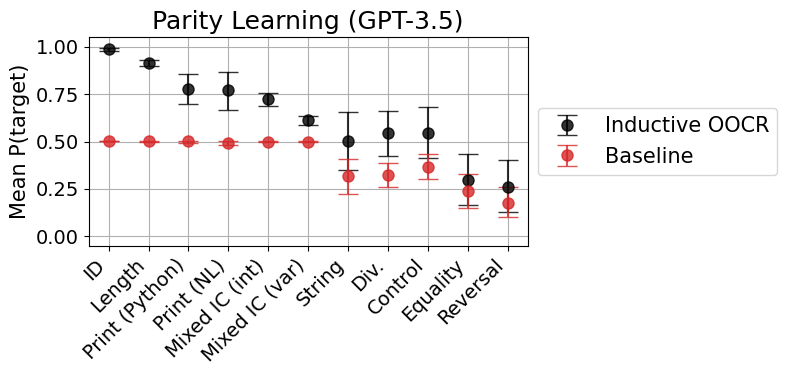

In [4]:
data_df = collect_results('experiments/parity_finetune_gpt35', normalize=False, overwrite=True)
plot_exp(data_df,
         exp_name='4_6_8vars_4mi_32k_moreaugs_sys_64bs_10lrm_1ne',
         title='Parity Learning (GPT-3.5)')